<a href="https://colab.research.google.com/github/Hypernating/50.039_FlightDelayPredictor/blob/Shrinidhi_branch/50_039_DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import glob

# Path
path = '*.csv'

# Load and sort CSV files
csv_files = sorted(glob.glob(path))
dfs = []

# Process each flight CSV
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Combine all flight data
combined = pd.concat(dfs, ignore_index=True)

# Save the final merged data
combined.to_csv('2016-2021.csv', index=False)

# Display first few rows
combined.head()

,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled Departure Time,Actual Departure Time,Departure Delay (Minutes),Scheduled Departure Datetime,Rounded Datetime,Air Temperature,Dew Temperature,Sea Level Pressure,Wind Direction,Wind Speed Rate,Sky Condition,Precip 1 Hour
0,DL,01/01/2016,446.0,N900PC,ATL,06:00,05:59,-1.0,2016-01-01 06:00:00,2016-01-01 06:00:00,0.437148,0.445804,0.547244,0.888889,0.300000,0.666667,0.0
1,DL,01/01/2016,462.0,N37700,SEA,07:00,06:59,-1.0,2016-01-01 07:00:00,2016-01-01 07:00:00,0.437148,0.445804,0.547244,0.888889,0.326316,0.740741,0.0
2,DL,01/01/2016,420.0,N712TW,SLC,07:00,07:06,6.0,2016-01-01 07:00:00,2016-01-01 07:00:00,0.437148,0.445804,0.547244,0.888889,0.326316,0.740741,0.0
3,DL,01/01/2016,2217.0,N374DA,SJU,07:00,06:57,-3.0,2016-01-01 07:00:00,2016-01-01 07:00:00,0.437148,0.445804,0.547244,0.888889,0.326316,0.740741,0.0
4,DL,01/01/2016,2825.0,N396DA,MIA,07:00,07:00,0.0,2016-01-01 07:00:00,2016-01-01 07:00:00,0.437148,0.445804,0.547244,0.888889,0.326316,0.740741,0.0


In [ ]:
import pandas as pd
import glob

# Get all CSV files in a folder
csv_files = glob.glob('*.csv')

# Read and combine them
df_list = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(df_list, ignore_index=True)

# Save to a new file
combined_df.to_csv('2016-2021_weather.csv', index=False)


CNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ========== Dataset ==========

class WeatherToDelayDataset(Dataset):
    def __init__(self, weather_df, delay_series):
        self.X, self.Y = self.format_data(weather_df, delay_series)

    def format_data(self, weather_df, delay_series):
        weather_cols = [
            "Air Temperature",
            "Dew Temperature",
            "Sea Level Pressure",
            "Wind Direction",
            "Wind Speed Rate",
            "Sky Condition",
            "Precip 1 Hour"
        ]

        # Drop rows with NaNs in either weather or delay
        df = weather_df[weather_cols].copy()
        df["Departure Delay"] = delay_series
        df = df.replace([np.inf, -np.inf], np.nan).dropna()

        scaler_X = StandardScaler()
        df[weather_cols] = scaler_X.fit_transform(df[weather_cols])

        scaler_y = StandardScaler()
        df["Departure Delay"] = scaler_y.fit_transform(df[["Departure Delay"]])

        weather_data = df[weather_cols].values.astype(np.float32)
        target_data = df["Departure Delay"].values.astype(np.float32)

        # Create sequences of 5
        X, Y = [], []
        for i in range(5, len(df)):
            prev_weather = np.vstack(weather_data[i-5:i])  # (5, 7)
            X.append(prev_weather)
            Y.append(target_data[i])

        X = np.expand_dims(np.array(X), axis=1)  # (N, 1, 5, 7)
        Y = np.array(Y).reshape(-1, 1)

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# ========== CNN Regressor ==========

class CNNDelayRegressor(nn.Module):
    def __init__(self, input_shape=(5, 7)):
        super(CNNDelayRegressor, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )

        self.fc1 = nn.Linear(64, 128)
        self.dropout = nn.Dropout(0.5)  # Increased for stronger regularization
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x1 = self.conv_block1(x)
        x2 = self.conv_block2(x1)
        x3 = self.conv_block3(x2)

        # Simple skip connection
        x1_resized = F.interpolate(x1, size=x3.shape[2:])
        x1_resized = F.pad(x1_resized, (0, 0, 0, 0, 0, 48))
        x = x3 + x1_resized

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

# ========== Training & Evaluation ==========

def train_and_evaluate(model, train_loader, test_loader, epochs=50, lr=1e-4):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, Y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss / len(train_loader):.4f}")

        model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for X_batch, Y_batch in test_loader:
                preds = model(X_batch)
                loss = criterion(preds, Y_batch)
                total_loss += loss.item()
        print(f"Test MSE Loss: {total_loss / len(test_loader):.4f}")

# ========== Load CSVs and Run ==========

df_flights = pd.read_csv("2016-2021.csv")
df_weather = pd.read_csv("2016-2021_weather.csv")

# Only keep the target column from flight data
departure_delay = df_flights["Departure Delay (Minutes)"]

# Create dataset from weather + delay
full_dataset = WeatherToDelayDataset(df_weather, departure_delay)

# Train/Test split
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train model
model = CNNDelayRegressor(input_shape=(5, 7))
train_and_evaluate(model, train_loader, test_loader)


Epoch 1/50 - Train Loss: 0.9984
Test MSE Loss: 1.0359
Epoch 2/50 - Train Loss: 0.9896
Test MSE Loss: 1.0321
Epoch 3/50 - Train Loss: 0.9885
Test MSE Loss: 1.0328
Epoch 4/50 - Train Loss: 0.9877
Test MSE Loss: 1.0320
Epoch 5/50 - Train Loss: 0.9877
Test MSE Loss: 1.0320
Epoch 6/50 - Train Loss: 0.9867
Test MSE Loss: 1.0326
Epoch 7/50 - Train Loss: 0.9864
Test MSE Loss: 1.0313
Epoch 8/50 - Train Loss: 0.9857
Test MSE Loss: 1.0311
Epoch 9/50 - Train Loss: 0.9867
Test MSE Loss: 1.0308
Epoch 10/50 - Train Loss: 0.9869
Test MSE Loss: 1.0304
Epoch 11/50 - Train Loss: 0.9859
Test MSE Loss: 1.0304
Epoch 12/50 - Train Loss: 0.9851
Test MSE Loss: 1.0298
Epoch 13/50 - Train Loss: 0.9855
Test MSE Loss: 1.0296
Epoch 14/50 - Train Loss: 0.9845
Test MSE Loss: 1.0295
Epoch 15/50 - Train Loss: 0.9847
Test MSE Loss: 1.0301
Epoch 16/50 - Train Loss: 0.9845
Test MSE Loss: 1.0287
Epoch 17/50 - Train Loss: 0.9849
Test MSE Loss: 1.0289
Epoch 18/50 - Train Loss: 0.9838
Test MSE Loss: 1.0288
Epoch 19/50 - Train

LSTM

Epoch 1, Train Loss: 1.0102, Test Loss: 1.0312
Epoch 2, Train Loss: 0.9935, Test Loss: 1.0312
Epoch 3, Train Loss: 0.9883, Test Loss: 1.0284
Epoch 4, Train Loss: 0.9861, Test Loss: 1.0293
Epoch 5, Train Loss: 0.9847, Test Loss: 1.0285
Epoch 6, Train Loss: 0.9837, Test Loss: 1.0277
Epoch 7, Train Loss: 0.9810, Test Loss: 1.0278
Epoch 8, Train Loss: 0.9812, Test Loss: 1.0270
Epoch 9, Train Loss: 0.9796, Test Loss: 1.0265
Epoch 10, Train Loss: 0.9788, Test Loss: 1.0282
Epoch 11, Train Loss: 0.9770, Test Loss: 1.0262
Epoch 12, Train Loss: 0.9755, Test Loss: 1.0270
Epoch 13, Train Loss: 0.9739, Test Loss: 1.0222
Epoch 14, Train Loss: 0.9742, Test Loss: 1.0228
Epoch 15, Train Loss: 0.9723, Test Loss: 1.0225
Epoch 16, Train Loss: 0.9708, Test Loss: 1.0217
Epoch 17, Train Loss: 0.9676, Test Loss: 1.0232
Epoch 18, Train Loss: 0.9661, Test Loss: 1.0205
Epoch 19, Train Loss: 0.9644, Test Loss: 1.0218
Epoch 20, Train Loss: 0.9627, Test Loss: 1.0180
Epoch 21, Train Loss: 0.9622, Test Loss: 1.0185
E

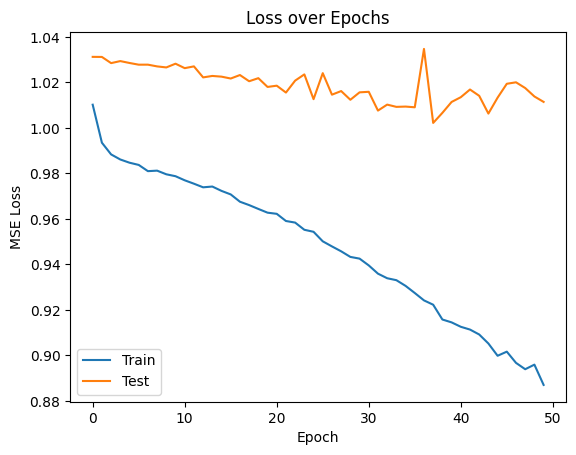

Train MAE: 0.45, Train RMSE: 0.93
Test MAE: 0.48, Test RMSE: 1.00


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden1=100, hidden2=60, hidden3=50):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden1, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden1 * 2, hidden2, batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(hidden2 * 2, hidden3, batch_first=True, bidirectional=True)

        self.batchnorm = nn.BatchNorm1d(hidden3 * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden3 * 2, 1)  # *2 for bidirectional

        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.squeeze(1)  # (B, T, F)

        x, _ = self.lstm1(x)
        x = self.relu(x)

        x, _ = self.lstm2(x)
        x = self.relu(x)

        x, _ = self.lstm3(x)
        x = self.relu(x)

        x = x.mean(dim=1)  # Global Average Pooling across time dimension (T)

        x = self.batchnorm(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Change input_size to 7 (number of weather features)
model = LSTMModel(input_size=7).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses, dev_losses = [], []

# Training loop
for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        loss = criterion(outputs, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        dev_loss = 0
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            dev_loss += loss.item()
        dev_losses.append(dev_loss / len(test_loader))

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {dev_losses[-1]:.4f}")

# Plot training and validation loss
plt.plot(train_losses, label='Train')
plt.plot(dev_losses, label='Test')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

def evaluate(model, loader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            outputs = model(xb).cpu().numpy()
            predictions.extend(outputs.flatten())  # Flatten and extend the list
            targets.extend(yb.cpu().numpy().flatten())  # Flatten and extend the list

    mae = np.mean(np.abs(np.array(predictions) - np.array(targets)))  # Convert to NumPy arrays
    rmse = np.sqrt(np.mean((np.array(predictions) - np.array(targets)) ** 2))  # Convert to NumPy arrays
    return mae, rmse

train_mae, train_rmse = evaluate(model, train_loader)
test_mae, test_rmse = evaluate(model, test_loader)

print(f"Train MAE: {train_mae:.2f}, Train RMSE: {train_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}, Test RMSE: {test_rmse:.2f}")
